In [ ]:
import time
import warnings
from collections import defaultdict
from multiprocessing import Process, Queue, queues as qsm

import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

DIR_PATH = "./Datasets"
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (28, 10)

# Data preparation

In [ ]:
df = pd.read_csv(f"{DIR_PATH}/phg_counts.csv").set_index("Unnamed: 0")
mutation_columns = list(df.columns)
df.head()

,T[T>G]T,T[T>C]T,T[T>A]T,G[T>G]T,G[T>C]T,G[T>A]T,C[T>G]T,C[T>C]T,C[T>A]T,A[T>G]T,...,T[C>T]A,T[C>A]C,T[C>G]C,T[C>T]C,T[C>A]G,T[C>G]G,T[C>T]G,T[C>A]T,T[C>G]T,T[C>T]T
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0009b464-b376-4fbc-8a56-da538269a02f,145,130,223,54,114,141,105,129,385,65,...,589,213,147,253,23,29,154,351,545,457
003819bc-c415-4e76-887c-931d60ed39e7,2,4,2,0,1,1,0,0,0,0,...,1,1,1,1,0,0,2,2,0,1
0040b1b6-b07a-4b6e-90ef-133523eaf412,145,160,110,55,169,51,103,261,166,100,...,202,218,81,179,45,11,112,224,200,203
00493087-9d9d-40ca-86d5-936f1b951c93,16,62,18,8,38,8,12,23,6,16,...,35,16,10,52,3,0,61,26,26,55
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,12,31,19,5,32,3,7,17,14,9,...,78,17,17,67,5,1,42,24,37,63


In [ ]:
df_add_info = pd.read_csv(f"{DIR_PATH}/phg_clincal_activities.csv").set_index("Unnamed: 0")
df_add_info = df_add_info[["organ", "tumour_type"]]
df_add_info.head()

,organ,tumour_type
Unnamed: 0,,
0009b464-b376-4fbc-8a56-da538269a02f,Ovary,Recurrent
003819bc-c415-4e76-887c-931d60ed39e7,CNS,Primary
0040b1b6-b07a-4b6e-90ef-133523eaf412,Liver,Primary
00493087-9d9d-40ca-86d5-936f1b951c93,CNS,Primary
00508f2b-36bf-44fc-b66b-97e1f3e40bfa,Pancreas,Primary


In [ ]:
df_add_info[df_add_info["organ"] == "Skin"]["tumour_type"].value_counts()

Metastatic    388
Recurrent      10
Primary         2
Name: tumour_type, dtype: int64

In [ ]:
df_add_info_reduced = df_add_info.dropna()
df_add_info_reduced["organ X tumour"] = df_add_info_reduced.apply(lambda x: str(x.organ) + " X " + str(x.tumour_type), axis = 1)
df_add_info_reduced.shape

(6195, 3)

In [ ]:
tumour_counts = df_add_info["tumour_type"].value_counts()
organ_counts = df_add_info["organ"].value_counts()
organ_x_tumour_counts = df_add_info_reduced["organ X tumour"].value_counts()
VALID_TUMORS = list(tumour_counts[tumour_counts > 100].index)
VALID_ORGANS = list(organ_counts[organ_counts > 100].index)
VALID_MIXED = list(organ_x_tumour_counts[organ_x_tumour_counts > 100].index)
print(len(VALID_TUMORS), len(VALID_ORGANS), len(VALID_MIXED))

2 20 18


In [ ]:
# cosmic = pd.read_csv("https://cog.sanger.ac.uk/cosmic-signatures-production/documents/COSMIC_v3.2_SBS_GRCh37.txt", sep='\t', index_col=0)
cosmic = pd.read_csv("./Datasets/cosmic_table.csv", index_col = 0)
cosmic = cosmic.T
cosmic.head()

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,A[C>T]A,A[C>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,8.861572e-04,0.002280,0.000177,0.001280,1.860330e-03,0.001220,0.000115,0.001140,0.025004,0.006321,...,0.000028,0.002250,2.550453e-04,0.003391,0.000416,0.004331,2.230396e-16,0.000055,0.000583,2.230396e-16
SBS2,5.800168e-07,0.000148,0.000052,0.000098,2.230064e-16,0.000133,0.000015,0.000091,0.000061,0.001380,...,0.000050,0.000205,2.230064e-16,0.000044,0.000117,0.000036,1.670048e-05,0.000070,0.000095,2.230064e-16
SBS3,2.080832e-02,0.016507,0.001751,0.012205,1.970788e-02,0.011705,0.000253,0.017407,0.014206,0.012405,...,0.006713,0.013005,1.520608e-02,0.008994,0.006933,0.013906,7.252901e-03,0.006283,0.008053,1.050420e-02
SBS4,4.219650e-02,0.033297,0.015599,0.029498,6.889428e-03,0.002840,0.001280,0.003550,0.008699,0.004180,...,0.009539,0.005620,2.409800e-03,0.000503,0.001740,0.000636,3.769687e-04,0.000174,0.002320,5.679529e-04
SBS5,1.199760e-02,0.009438,0.001850,0.006609,1.009798e-02,0.005699,0.001720,0.010098,0.032593,0.017896,...,0.004789,0.008748,1.799640e-02,0.009708,0.012697,0.018496,5.218956e-03,0.006559,0.006939,1.349730e-02


In [ ]:
# Default - use all data to create distributions
# Organ - partition data by organ type
# Tumour Type - partition data by tumour type
# Organ X Tumour Type - partition data by cartesian product of organ and tumour types

In [ ]:
default_case = dict()
default_case["All"] = df

In [ ]:
organ_case = dict()
for organ_type in VALID_ORGANS:
    idxs = df_add_info[df_add_info["organ"] == organ_type].index
    organ_case[f"X_{organ_type}"] = df.loc[idxs]

In [ ]:
tumour_case = dict()
for tumour_type in VALID_TUMORS:
    idxs = df_add_info[df_add_info["tumour_type"] == tumour_type].index
    tumour_case[f"X_{tumour_type}"] = df.loc[idxs]

In [ ]:
organ_x_tumour_case = dict()
for organ_x_tumour in VALID_MIXED:
    idxs = df_add_info_reduced[df_add_info_reduced['organ X tumour'] == organ_x_tumour].index
    organ_x_tumour_case[f"X_{organ_x_tumour}"] = df.loc[idxs]

In [ ]:
CASES = [("All", default_case), ("Organs", organ_case), ("Tumour", tumour_case), ("Organs x Tumour", organ_x_tumour_case)]

# Analyzing results

In [ ]:
advi_results = defaultdict(dict)

for case_name, case_data in CASES:
    for subcase_name in case_data:
        df = pd.read_csv(f"./Results/ADVI/{case_name}_{subcase_name}.csv").drop("Unnamed: 0", axis = 1)
        advi_results[case_name][subcase_name] = df

In [ ]:
mcmc_results = defaultdict(dict)

for case_name, case_data in CASES:
    for subcase_name in case_data:
        df = pd.read_csv(f"./Results/MetropolisHastings/{case_name}_{subcase_name}.csv").drop("Unnamed: 0", axis = 1)
        mcmc_results[case_name][subcase_name] = df

## Results visualization for ADVI for each signature

Signature - SBS1


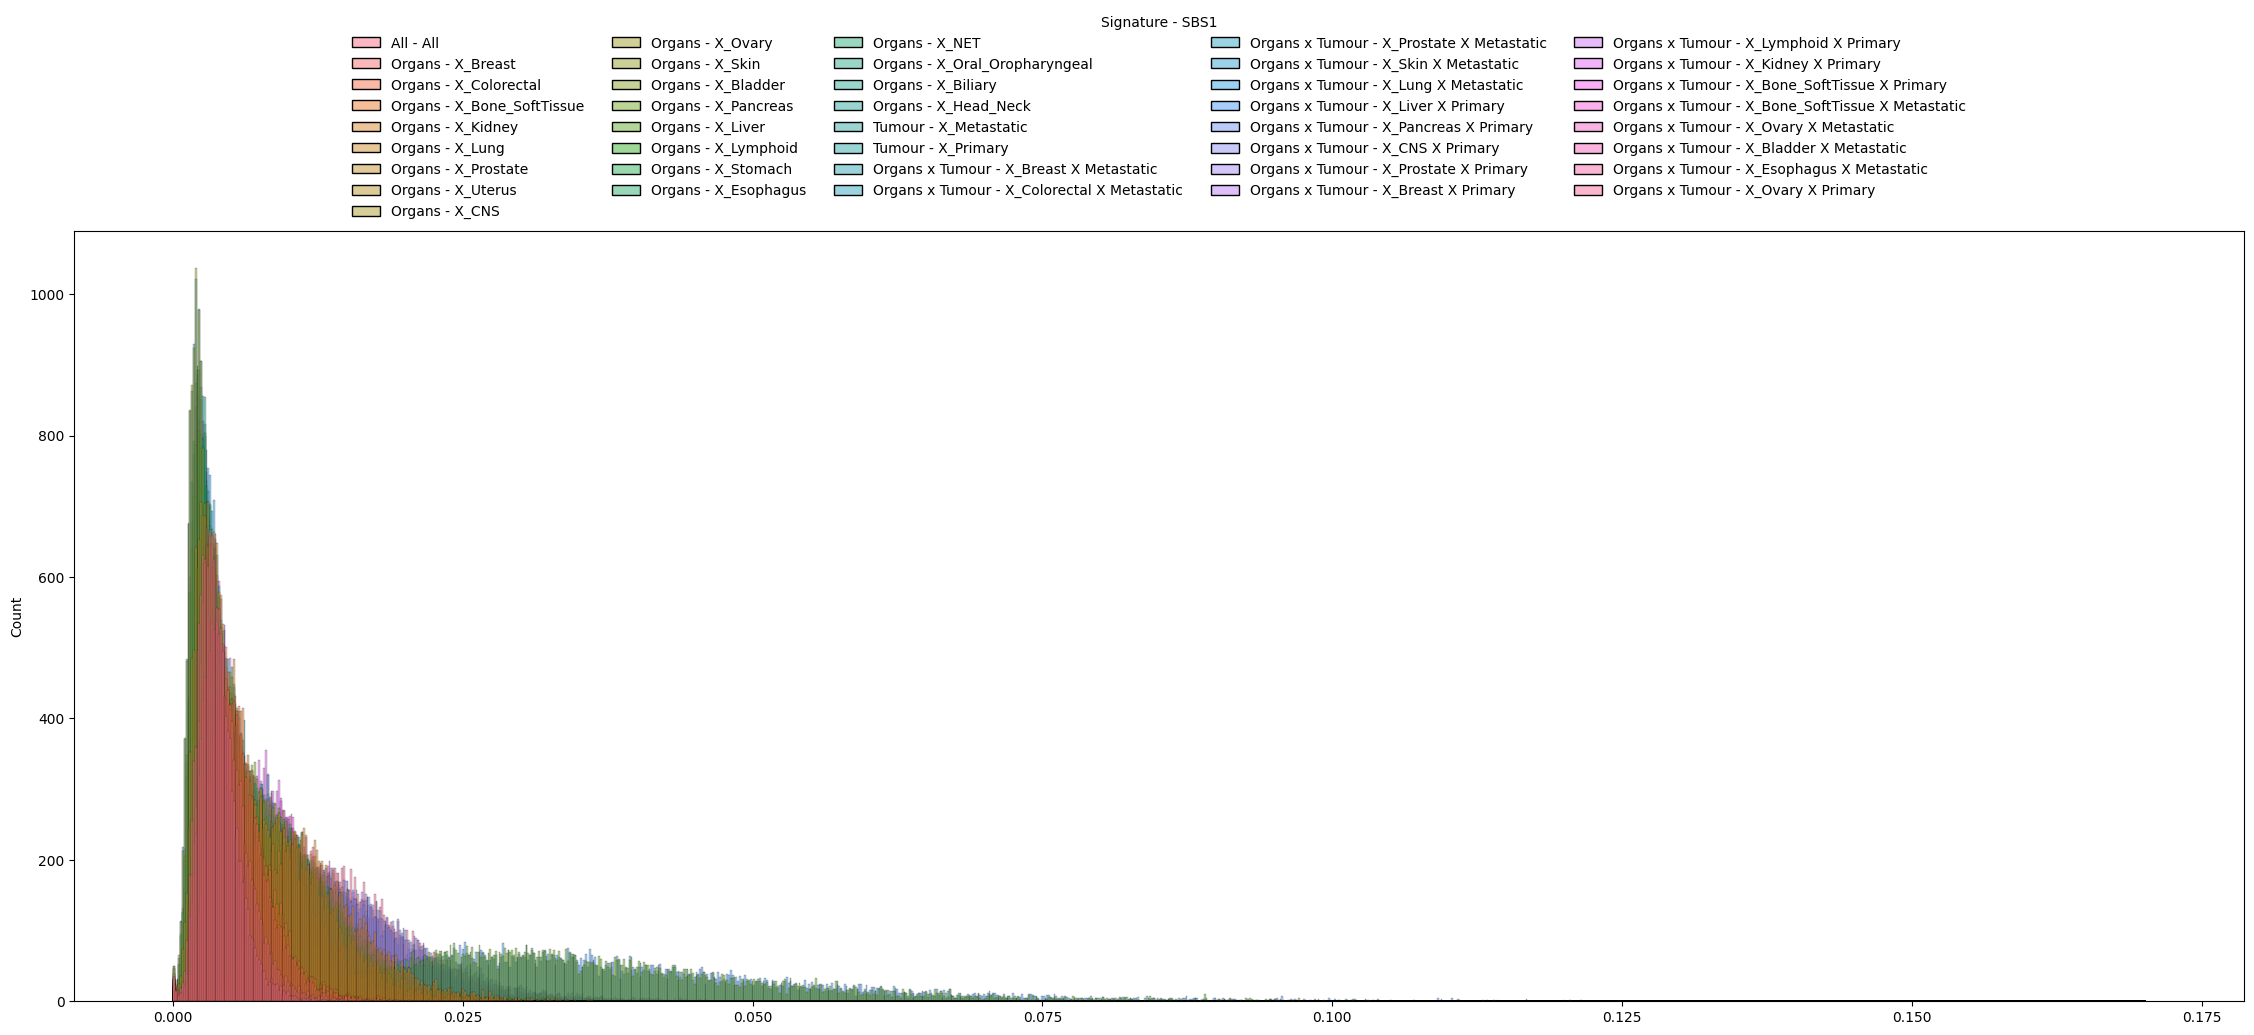

In [ ]:
for signature in cosmic.T.columns[:1]:
    print(f"Signature - {signature}")
    res_sign = dict()
    for case_name, case_data in CASES:
        for subcase_name in case_data:
            res_sign[f"{case_name} - {subcase_name}"] = advi_results[case_name][subcase_name][signature]
    res_sign = pd.DataFrame(data = res_sign)
    fig = sns.histplot(data = res_sign)
    sns.move_legend(
        fig, "lower center", ncol = 5, bbox_to_anchor=(.5, 1), title=f"Signature - {signature}", frameon=False,
    )
    plt.show()
    print()

## Results visualization for MCMC Metropolis Hastings for each signature

In [ ]:
for signature in cosmic.T.columns[:1]:
    print(f"Signature - {signature}")
    res_sign = dict()
    for case_name, case_data in CASES:
        for subcase_name in case_data:
            res_sign[f"{case_name} - {subcase_name}"] = mcmc_results[case_name][subcase_name][signature]
    
    res_sign = pd.DataFrame(data = res_sign)
    fig = sns.histplot(data = res_sign)
    sns.move_legend(
        fig, "lower center", ncol = 5, bbox_to_anchor=(.5, 1), title=f"Signature - {signature}", frameon=False,
    )
    plt.show()
    print()

## Results visualization for different organs

In [ ]:
case_name, case_data = CASES[1]
case_name_1, case_data_1 = CASES[0]

In [ ]:
def create_sbs_organs_mcmc(case_dfs: dict):
    activities = list()
    for subcase_name in case_data:
        most_active = list((case_dfs[subcase_name].mean(axis = 0) > 0.05).values)
        activities.append([subcase_name[2:], *most_active])
    return pd.DataFrame(data = activities, columns = ["Organ", *list(case_dfs[subcase_name].columns)]).set_index("Organ")

sbs_organs_mcmc = create_sbs_organs_mcmc(mcmc_results[case_name])

In [ ]:
# def get_signature_data(signature: str, thetas_results: pd.DataFrame):
#     thetas = dict()
#     for subcase_name in case_data:
#         thetas[subcase_name[2:]] = thetas_results[case_name][subcase_name][signature]
#     thetas = pd.DataFrame(data = thetas)
#     return thetas

# def plot_histograms(advi_thetas: pd.DataFrame, mcmc_thetas: pd.DataFrame, signature: str):
#     fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(30, 20), sharex=True)
#     fig.suptitle(f'Signature - {signature}', fontsize=40)
#     fig1 = sns.histplot(data = advi_thetas, ax = axs[0])
#     sns.move_legend(
#         fig1, "lower center", ncol = 5, bbox_to_anchor=(.5, 1), title=f"ADVI", frameon=False,
#     )
#     fig2 = sns.histplot(data = mcmc_thetas, ax = axs[1])
#     sns.move_legend(
#         fig2, "lower center", ncol = 5, bbox_to_anchor=(.5, 1), title=f"MCMC", frameon=False,
#     )
#     plt.show()

# SKIPPED_SIGNATURES = list()

# for signature in cosmic.index[:1]:
#     plt.rcParams["figure.figsize"] = (28, 10)
#     print(f"Signature - {signature}")
#     advi_thetas = get_signature_data(signature, advi_results)
#     mcmc_thetas = get_signature_data(signature, mcmc_results)

#     if advi_thetas.shape[1] == 0:
#         SKIPPED_SIGNATURES.append(signature)
#         continue

#     plot_histograms(advi_thetas, mcmc_thetas, signature)

Signature - SBS1


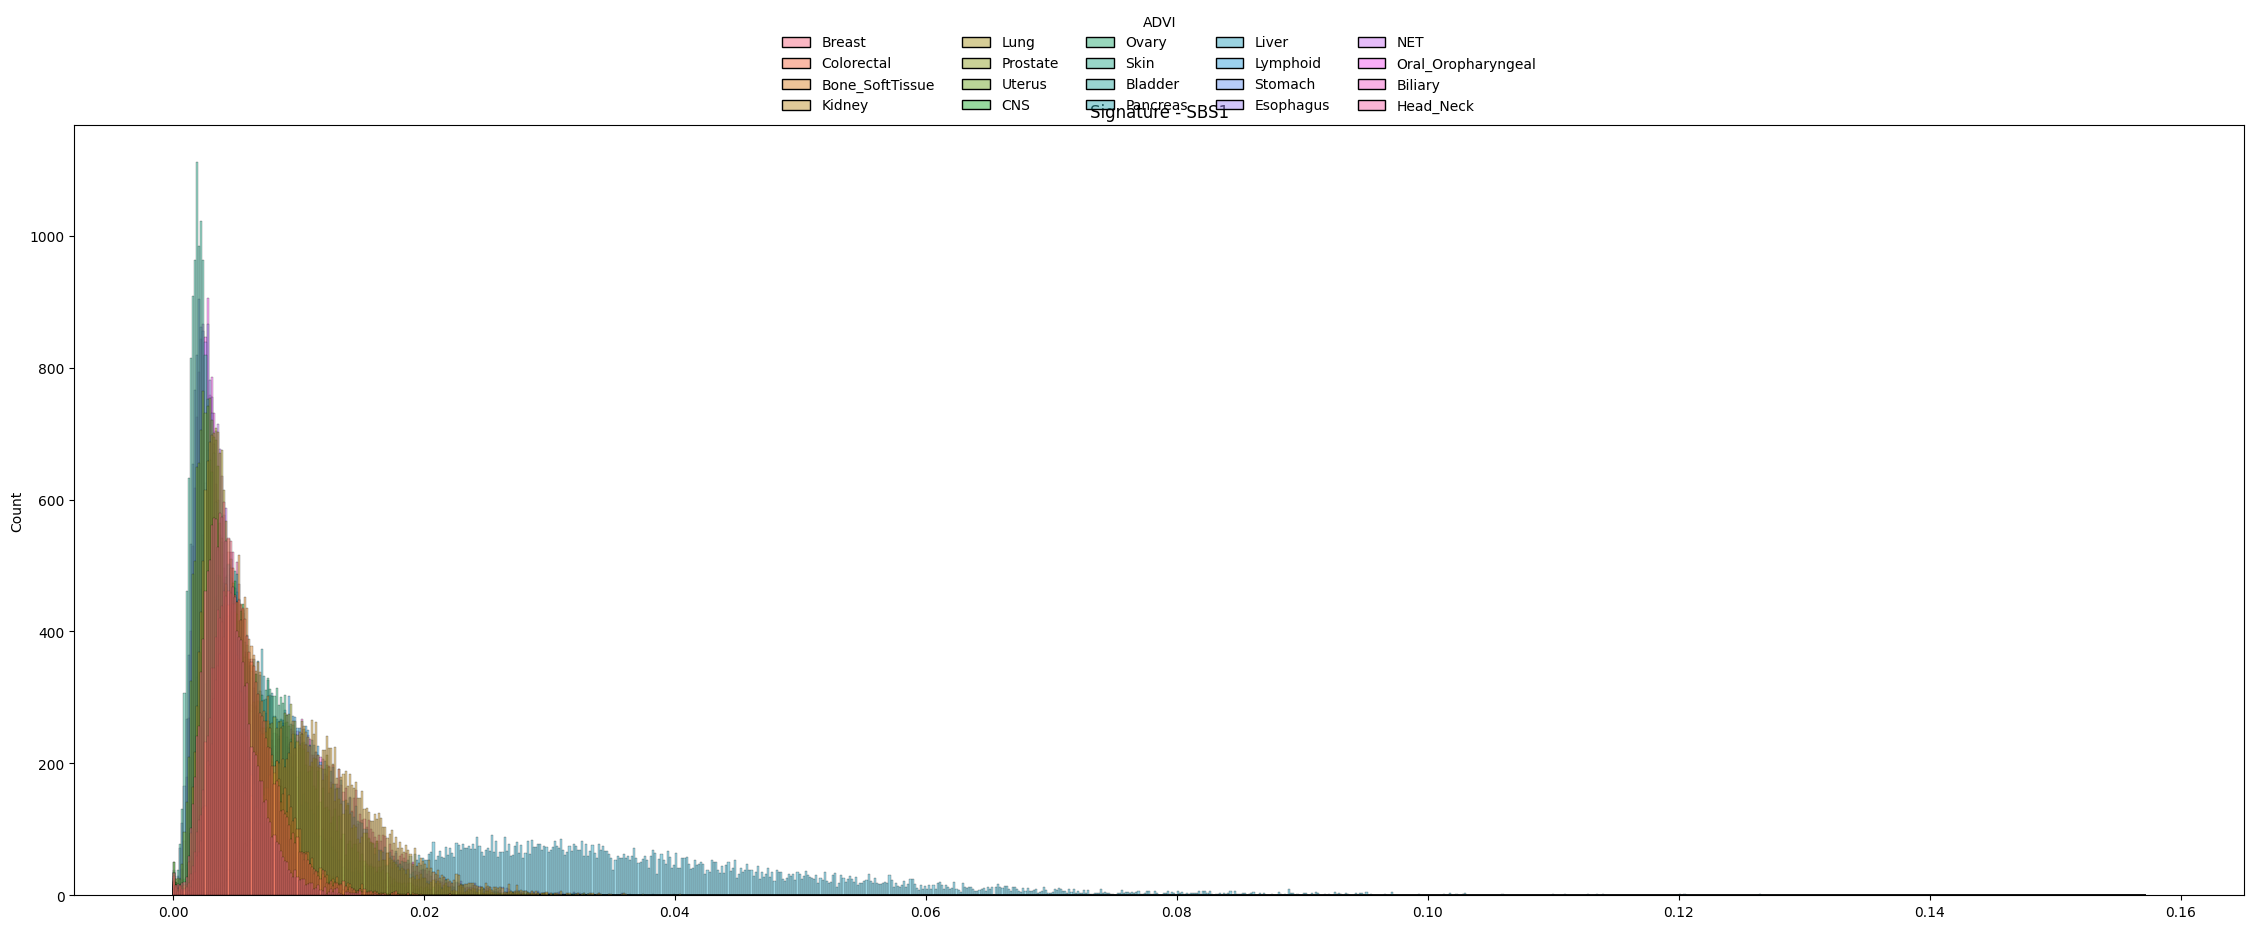

In [ ]:
def get_signature_data(signature: str, thetas_results: pd.DataFrame):
    thetas = dict()
    for subcase_name in case_data:
        thetas[subcase_name[2:]] = thetas_results[case_name][subcase_name][signature]
    
    thetas = pd.DataFrame(data = thetas)
    return thetas

def plot_histograms(advi_thetas: pd.DataFrame, signature: str):
    fig = sns.histplot(data = advi_thetas)
    sns.move_legend(
        fig, "lower center", ncol = 5, bbox_to_anchor=(.5, 1), title=f"ADVI", frameon=False,
    )
    plt.title(f'Signature - {signature}')
    plt.show()

SKIPPED_SIGNATURES = list()

for signature in cosmic.index[:1]:
    plt.rcParams["figure.figsize"] = (28, 10)
    print(f"Signature - {signature}")
    advi_thetas = get_signature_data(signature, advi_results)

    if advi_thetas.shape[1] == 0:
        SKIPPED_SIGNATURES.append(signature)
        continue
    
    plot_histograms(advi_thetas, signature)

In [ ]:
# plt.rcParams["figure.figsize"] = (10, 15)

# for subcase_name in list(case_data.keys()):
#     sbs_columns = sbs_organs_mcmc.columns[sbs_organs_mcmc.loc[subcase_name[2:]]]
#     advi_sbs_ratios = advi_results[case_name][subcase_name].mean(axis = 0).to_frame()
#     advi_ratios_sum = advi_sbs_ratios.sum()
#     advi_sbs_ratios = advi_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
#     advi_sbs_ratios["method"] = "ADVI"
#     mcmc_sbs_ratios = mcmc_results[case_name][subcase_name].mean(axis = 0).to_frame()
#     mcmc_ratios_sum = mcmc_sbs_ratios.sum()
#     mcmc_sbs_ratios = mcmc_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
#     mcmc_sbs_ratios["method"] = "MCMC"
#     sbs_ratios = pd.concat((advi_sbs_ratios, mcmc_sbs_ratios))
#     fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "method")
#     plt.title(f"Organ - {subcase_name[2:]}, ADVI ratios sum - {advi_ratios_sum.values}, MCMC ratios sum - {mcmc_ratios_sum.values}", fontsize=15)
#     plt.show(fig)

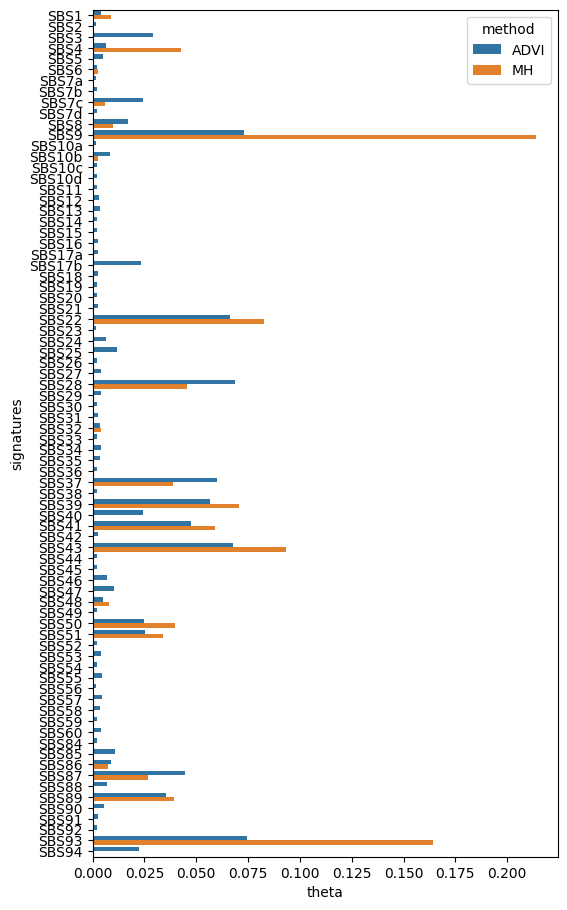

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)
advi_sbs_ratios = advi_results[case_name_1][case_name_1].mean(axis = 0).to_frame()
advi_sbs_ratios = advi_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios["method"] = "ADVI"
mcmc_sbs_ratios = mcmc_results[case_name_1][case_name_1].mean(axis = 0).to_frame()
mcmc_sbs_ratios = mcmc_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
mcmc_sbs_ratios["method"] = "MH"
sbs_ratios = pd.concat((advi_sbs_ratios, mcmc_sbs_ratios))
fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "method")
plt.show(fig)

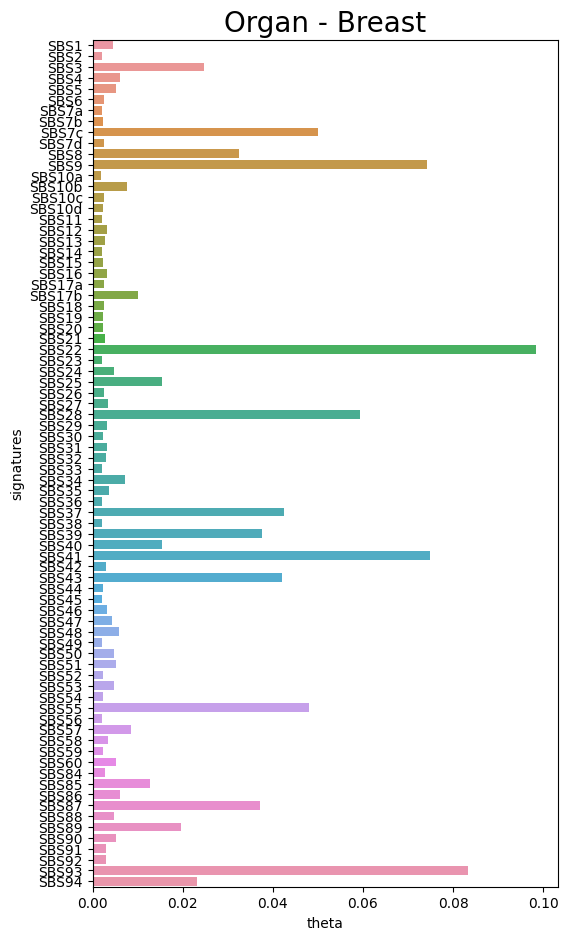

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)

for subcase_name in list(case_data.keys())[:1]:
    advi_sbs_ratios = advi_results[case_name][subcase_name].mean(axis = 0).to_frame()
    advi_sbs_ratios = advi_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
    advi_sbs_ratios["method"] = "ADVI"
    sbs_ratios = advi_sbs_ratios
    fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures")
    plt.title(f"Organ - {subcase_name[2:]}", fontsize=20)
    plt.show(fig)

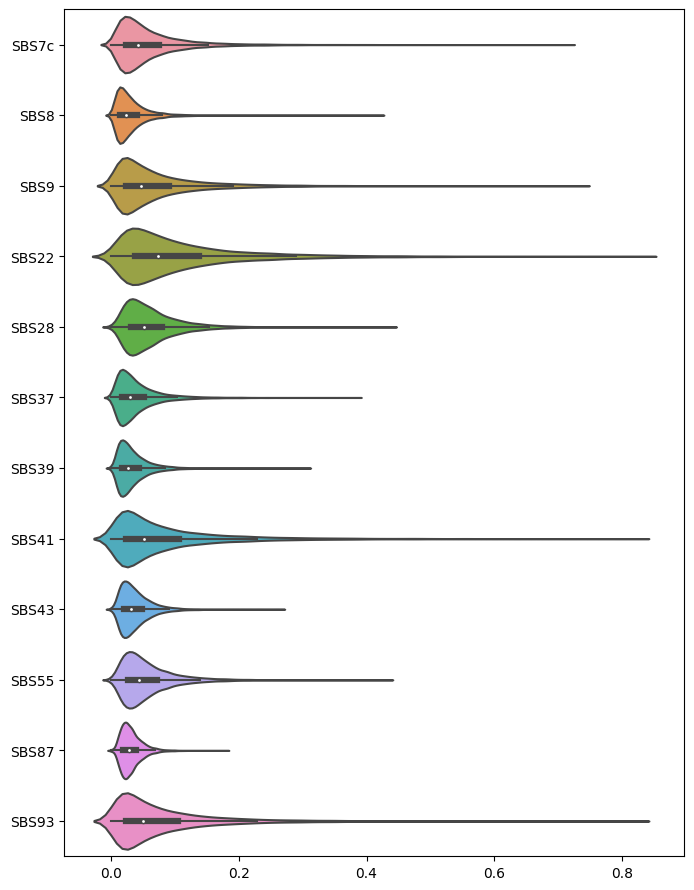

In [ ]:
plt.rcParams["figure.figsize"] = (8, 11)

for subcase_name in list(case_data.keys())[:1]:
    advi_sbs_ratios = advi_results[case_name][subcase_name].median(axis = 0).to_frame()
    advi_sbs_ratios = advi_sbs_ratios.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
    left_sbs = advi_sbs_ratios[advi_sbs_ratios["theta"] >= 0.02]["signatures"]
    sbs_ratios = advi_results[case_name][subcase_name][left_sbs]
    fig = sns.violinplot(data = sbs_ratios, orient = "h", scale = "count")
    # plt.title(f"Organ - {subcase_name[2:]}", fontsize=20)
    plt.show(fig)

## Other results

In [ ]:
cls_res = pd.read_csv("./Results/Classification/AUC_for_each_organ.csv", index_col=0)
cls_res.head(20)

,Organ,ROC-AUC,TN,FP,FN,TP
0,Ovary,0.931702,132,12,15,88
1,CNS,0.976661,67,11,11,273
2,Liver,0.981531,35,13,6,320
3,Pancreas,0.950617,68,7,42,282
4,Kidney,0.962063,88,12,11,178
5,Prostate,0.986105,401,12,19,222
6,Thyroid,0.958333,0,0,2,46
7,Colorectal,0.962170,489,4,16,44
8,Lymphoid,0.985149,0,0,3,199
9,Uterus,0.943553,64,2,17,34


In [ ]:
organ_auc = cls_res[["Organ", "ROC-AUC"]]
organ_auc = organ_auc.set_index("Organ")
organ_auc = organ_auc.sort_values(by = "ROC-AUC")
organ_auc.loc["All", "ROC-AUC"] = 0.7696301103179753
organ_auc

,ROC-AUC
Organ,
Skin,0.435567
Cervix,0.800000
Head_Neck,0.829738
NET,0.910000
Ovary,0.931702
Uterus,0.943553
Lung,0.944041
Pancreas,0.950617
Thyroid,0.958333


<AxesSubplot:xlabel='Organ', ylabel='ROC-AUC'>

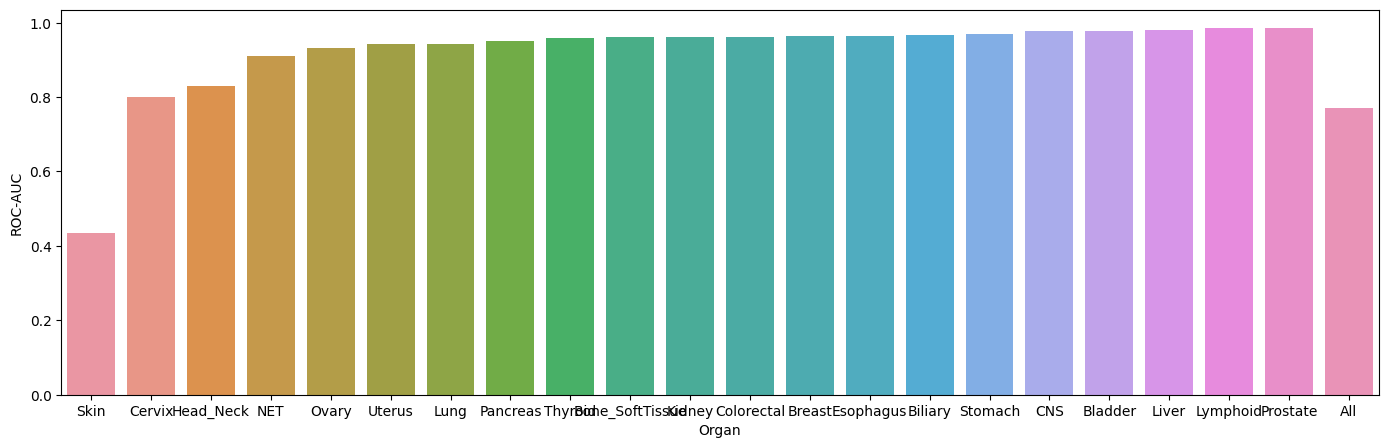

In [ ]:
plt.rcParams["figure.figsize"] = (17, 5)
sns.barplot(data = organ_auc.reset_index(), x = "Organ", y = "ROC-AUC")

In [ ]:
case_name_3, case_data_3 = CASES[3]
case_data_3.keys()

dict_keys(['X_Breast X Metastatic', 'X_Colorectal X Metastatic', 'X_Prostate X Metastatic', 'X_Skin X Metastatic', 'X_Lung X Metastatic', 'X_Liver X Primary', 'X_Pancreas X Primary', 'X_CNS X Primary', 'X_Prostate X Primary', 'X_Breast X Primary', 'X_Lymphoid X Primary', 'X_Kidney X Primary', 'X_Bone_SoftTissue X Primary', 'X_Bone_SoftTissue X Metastatic', 'X_Ovary X Metastatic', 'X_Bladder X Metastatic', 'X_Esophagus X Metastatic', 'X_Ovary X Primary'])

In [ ]:
cases_needed = ['X_Bone_SoftTissue X Primary', 'X_Bone_SoftTissue X Metastatic']

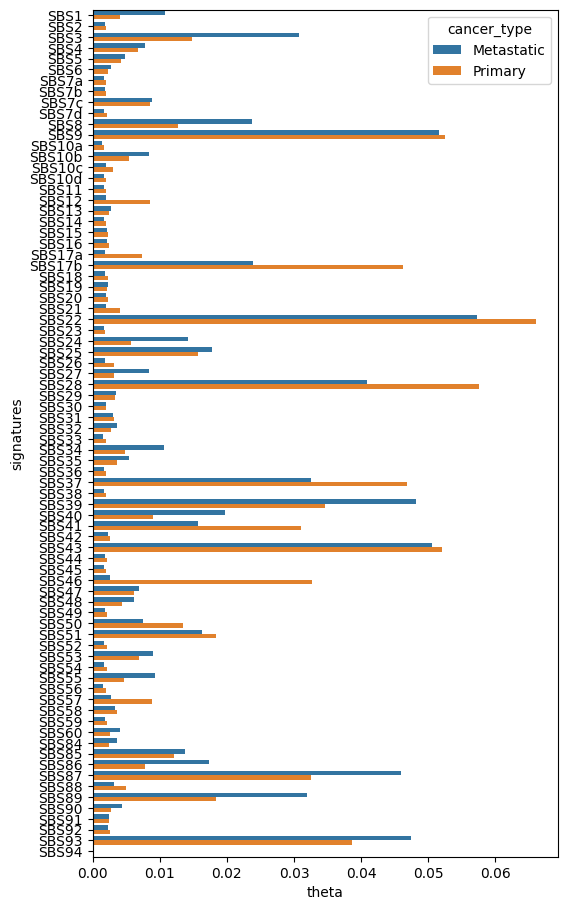

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)

advi_sbs_ratios_metastatic = advi_results[case_name_3]['X_Bone_SoftTissue X Primary'].median(axis = 0).to_frame()
advi_sbs_ratios_metastatic = advi_sbs_ratios_metastatic.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_metastatic["cancer_type"] = "Metastatic"
advi_sbs_ratios_primary = advi_results[case_name_3]['X_Bone_SoftTissue X Metastatic'].median(axis = 0).to_frame()
advi_sbs_ratios_primary = advi_sbs_ratios_primary.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_primary["cancer_type"] = 'Primary'
sbs_ratios = pd.concat((advi_sbs_ratios_metastatic, advi_sbs_ratios_primary))
signature_to_leave = sbs_ratios.loc[sbs_ratios["theta"] > 0.015, "signatures"].unique()

fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "cancer_type")
plt.show(fig)

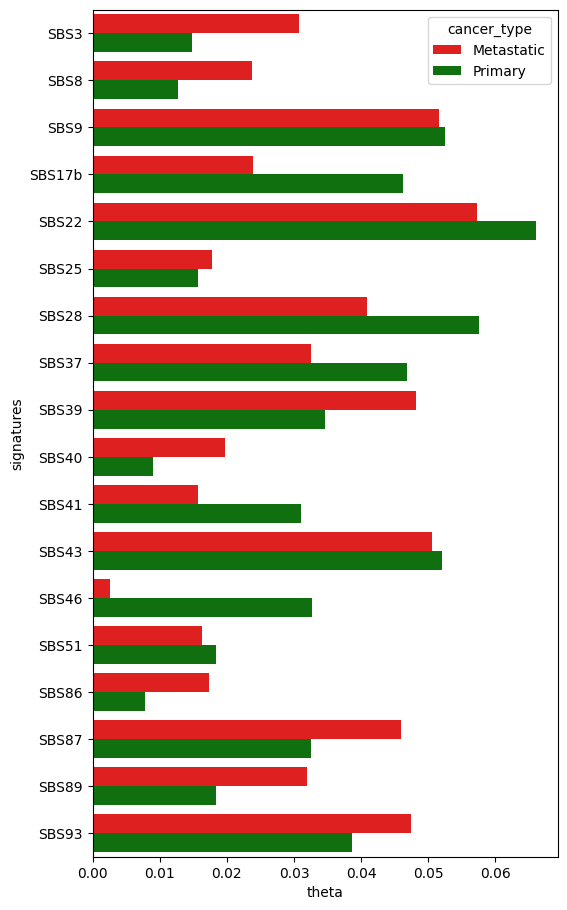

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)

advi_sbs_ratios_metastatic = advi_results[case_name_3]['X_Bone_SoftTissue X Primary'].median(axis = 0).to_frame()
advi_sbs_ratios_metastatic = advi_sbs_ratios_metastatic.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_metastatic["cancer_type"] = "Metastatic"
advi_sbs_ratios_primary = advi_results[case_name_3]['X_Bone_SoftTissue X Metastatic'].median(axis = 0).to_frame()
advi_sbs_ratios_primary = advi_sbs_ratios_primary.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_primary["cancer_type"] = 'Primary'
sbs_ratios = pd.concat((advi_sbs_ratios_metastatic, advi_sbs_ratios_primary))
signature_to_leave = sbs_ratios.loc[sbs_ratios["theta"] > 0.015, "signatures"].unique()
sbs_ratios = sbs_ratios.loc[sbs_ratios["signatures"].isin(signature_to_leave)]
fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "cancer_type", palette=['red', 'green'])
plt.show(fig)

In [ ]:
case_name_4, case_data_4 = CASES[2]

In [ ]:
case_data_4.keys()

dict_keys(['X_Metastatic', 'X_Primary'])

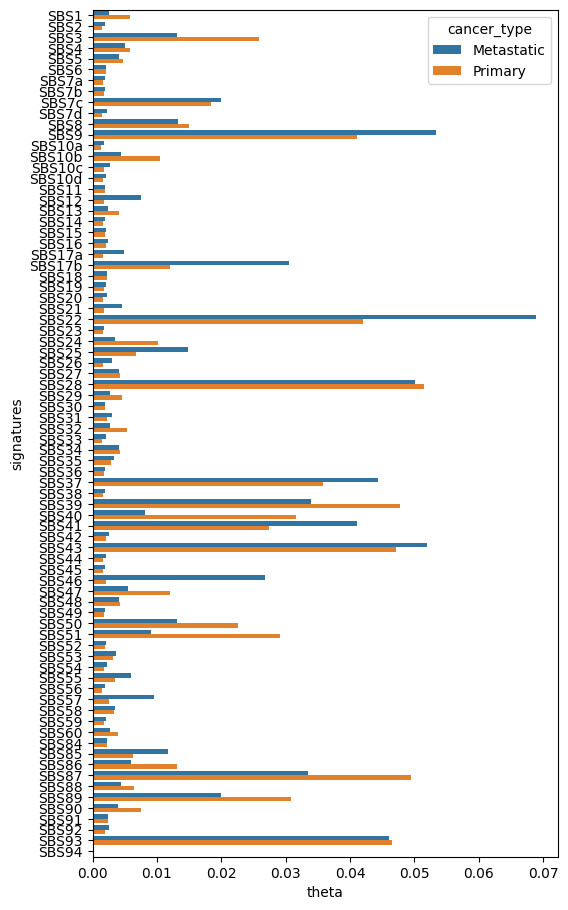

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)

advi_sbs_ratios_metastatic = advi_results[case_name_4]['X_Metastatic'].median(axis = 0).to_frame()
advi_sbs_ratios_metastatic = advi_sbs_ratios_metastatic.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_metastatic["cancer_type"] = "Metastatic"
advi_sbs_ratios_primary = advi_results[case_name_4]['X_Primary'].median(axis = 0).to_frame()
advi_sbs_ratios_primary = advi_sbs_ratios_primary.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_primary["cancer_type"] = 'Primary'
sbs_ratios = pd.concat((advi_sbs_ratios_metastatic, advi_sbs_ratios_primary))

fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "cancer_type")
plt.show(fig)

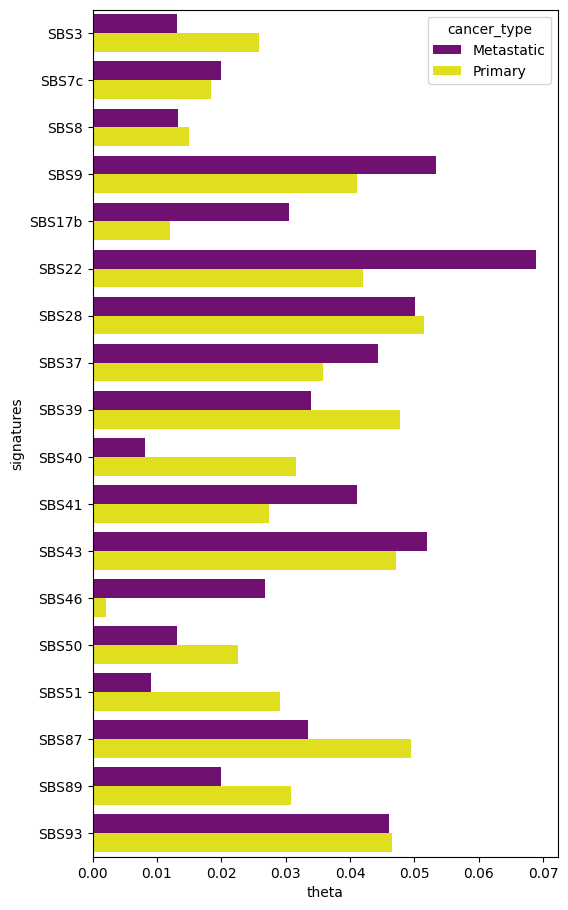

In [ ]:
plt.rcParams["figure.figsize"] = (6, 11)

advi_sbs_ratios_metastatic = advi_results[case_name_4]['X_Metastatic'].median(axis = 0).to_frame()
advi_sbs_ratios_metastatic = advi_sbs_ratios_metastatic.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_metastatic["cancer_type"] = "Metastatic"
advi_sbs_ratios_primary = advi_results[case_name_4]['X_Primary'].median(axis = 0).to_frame()
advi_sbs_ratios_primary = advi_sbs_ratios_primary.reset_index().rename(columns = {"index" : "signatures", 0: "theta"})
advi_sbs_ratios_primary["cancer_type"] = 'Primary'
sbs_ratios = pd.concat((advi_sbs_ratios_metastatic, advi_sbs_ratios_primary))
signature_to_leave = sbs_ratios.loc[sbs_ratios["theta"] > 0.015, "signatures"].unique()
sbs_ratios = sbs_ratios.loc[sbs_ratios["signatures"].isin(signature_to_leave)]

fig = sns.barplot(data = sbs_ratios, x = "theta", y = "signatures", hue = "cancer_type",  palette=['purple', 'yellow'])
plt.show(fig)